In [73]:
%run init_notebook.py

In [74]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby

In [75]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
from statsmodels.tsa.stattools import adfuller

# load

In [116]:
topics = load_pd_df('lda_topics_smooth.feather').reset_index()
topics['date'] = topics['date'].apply(lambda x: datetime(x.year, x.month, x.day))
# topics = topics.set_index('date').join(pd.DataFrame(dict_smoothed, index=tlda.date.drop_duplicates()).add_suffix('_s'), how='left')
topics.set_index('date', inplace=True)

hhp = load_pd_df('hhp_processed.feather')

pi = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [77]:
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

In [162]:
df = pd_join_dfs(
    [
        pi[['pi_de', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']],
        hhp.set_index('date_recorded')[
            ['date_forecast', 'pi_exp_WY', 'pi_exp_MY', 'pi_perc_MY', 'pi_perc_WY', 'hhinc_delta', 'delta_pe_WY', 'id']
        ],
        topics.drop('id', axis=1), #[[i for i in topics.columns if i.split('_')[-1] == "s"]],
        mir.ecb_rate,
        bei.bei,
    ],
    index_name='date_recorded'
)
df['week_recorded'] = df.index.to_period('W').to_timestamp()

In [220]:
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)

<AxesSubplot: xlabel='date_recorded'>

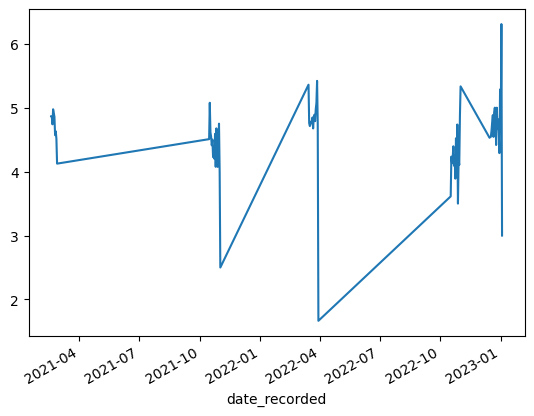

In [223]:
hhp.groupby('date_recorded')['ecbtrust'].mean().dropna().plot()

# validate news

<AxesSubplot: xlabel='date'>

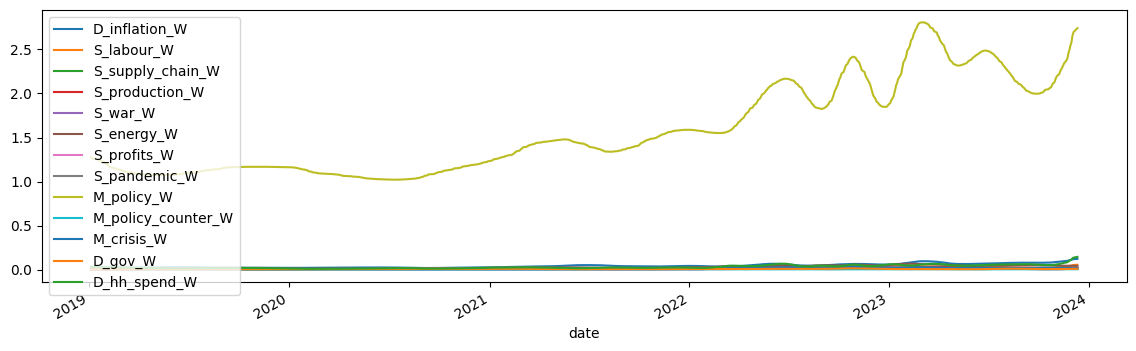

In [129]:
topics_w = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]].drop_duplicates().copy() #
# topics_w = topics_w.apply(lambda x: (x - x.min())/(x.max() - x.min())) 
topics_w.plot(legend=True, figsize=(14,4))

<AxesSubplot: xlabel='date'>

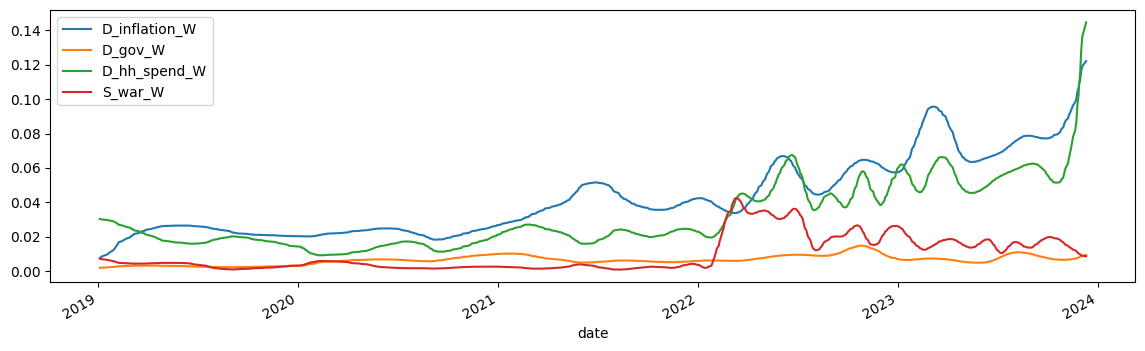

In [131]:
topics_w[
    ['D_inflation_W', "D_gov_W", "D_hh_spend_W", "S_war_W"] # "M_policy_W", "M_policy_counter_W", "M_crisis_W",]
].plot(figsize=(14,4))

In [ ]:
sub = topics_w[['D_inflation_W', 

In [80]:
sub = topics_w[['S_war_W', 'S_pandemic_W', 'D_inflation_W']].join(
    hhp.groupby('week_recorded')[['percprob_covid', 'percprob_war']].mean().dropna().apply(lambda x: (x - x.min())/(x.max() - x.min()))
)

<AxesSubplot: xlabel='date'>

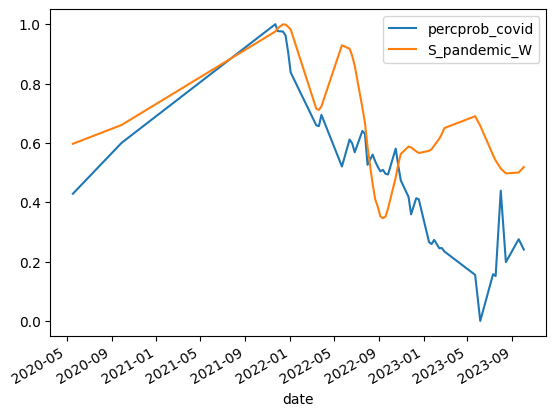

In [81]:
sub[['percprob_covid', 'S_pandemic_W']].dropna().plot()

<AxesSubplot: xlabel='date'>

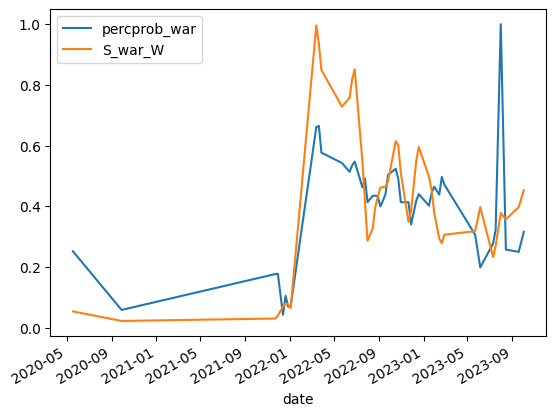

In [82]:
sub[['percprob_war', 'S_war_W']].dropna().plot()

## Does surprise inflation elicit higher news-paper reporting?

In [183]:
sub = df.groupby('week_recorded')[
    ['pi_de_Y', 'pi_de_surprise_Y', 'pi_perc_WY', 'ecb_rate', 'D_inflation_W'] # 'D_inflation_W_diff']
].last().dropna().drop_duplicates().copy()

In [185]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")

pi_de_Y ADF p-val: 0.00010065904875317684
pi_de_surprise_Y ADF p-val: 0.21568883223183744
pi_perc_WY ADF p-val: 0.16789199645245878
ecb_rate ADF p-val: 0.6358027448252145
D_inflation_W ADF p-val: 0.4761741632967869


In [191]:
jtest = select_coint_rank(sub, 0, 15, signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5            nan          69.82
  1   5          295.1          47.85
  2   5          31.83          29.80
  3   5          9.715          15.49
-------------------------------------


3

In [193]:
vecm = VECM(sub, coint_rank=jtest.rank).fit()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [194]:
vecm.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_de_Y,-0.1589,0.150,-1.057,0.290,-0.454,0.136
L1.pi_de_surprise_Y,-0.2216,0.198,-1.120,0.263,-0.609,0.166
L1.pi_perc_WY,1.4286,0.524,2.725,0.006,0.401,2.456
L1.ecb_rate,0.1246,0.507,0.246,0.806,-0.868,1.118
L1.D_inflation_W,0.0826,0.110,0.754,0.451,-0.132,0.297
,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_de_Y,-0.0576,0.224,-0.257,0.797,-0.497,0.382
L1.pi_de_surprise_Y,-0.5980,0.295,-2.026,0.043,-1.176,-0.020
L1.pi_perc_WY,1.4552,0.782,1.861,0.063,-0.077,2.988
L1.ecb_rate,0.0155,0.756,0.021,0.984,-1.465,1.496


<AxesSubplot: xlabel='week_recorded'>

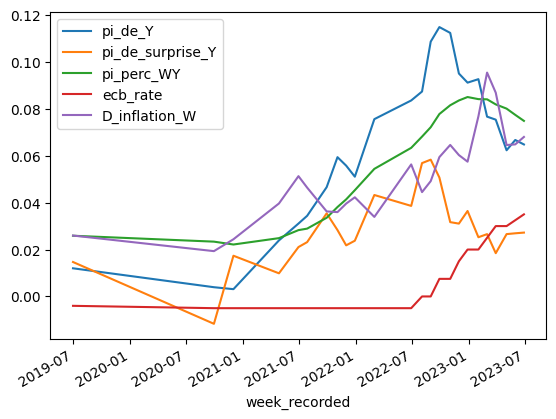

In [197]:
sub.plot()

In [200]:
vecm.test_granger_causality('D_inflation_W', 'pi_perc_WY').summary()

Test statistic,Critical value,p-value,df
2.309,3.316,0.117,"(2, 30)"


In [203]:
# VAR

In [204]:
sub_d = sub.diff().dropna().copy()

In [205]:
var = VAR(sub_d).fit()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [206]:
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, Mar, 2024
Time:                     15:11:09
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -50.0999
Nobs:                     22.0000    HQIC:                  -51.2372
Log likelihood:           441.382    FPE:                4.23148e-23
AIC:                     -51.5877    Det(Omega_mle):     1.26711e-23
--------------------------------------------------------------------
Results for equation pi_de_Y
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.003066         0.002582            1.187           0.235
L1.pi_de_Y                 -0.078006         0.222603           -0.350           0.726
L1.pi_de_surprise_Y         0.5837

<AxesSubplot: xlabel='week_recorded'>

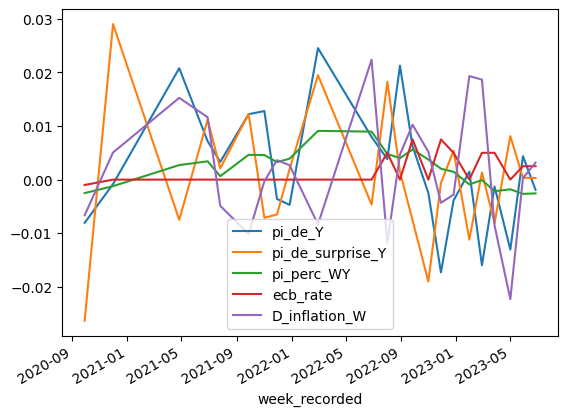

In [211]:
sub_d.plot()

In [210]:
var.test_causality('pi_perc_WY', 'pi_de_surprise_Y').summary()

Test statistic,Critical value,p-value,df
0.6307,3.960,0.429,"(1, 80)"
